In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import beam
%matplotlib inline
#from importlib import reload
reload(beam)

<module 'beam' from 'beam.pyc'>

# 1D beam shaping
To explain the concept in the paper, I'll start with an explanation of how to reshape a beam using a smoothly-varying phase element.  The basic principle is quite simple: chop the beam up into chunks that contain equal amounts of power, then distribute these equally in the target plane.  If you draw lines from the points in the starting beam to the points in the finishing beam, that shows the tilt that you need at each point.  Integrating over the tilts gives you a wavefront, which we can apply using the SLM to reshape the beam.

The code below draws a figure that illustrates this approach, linking points with equal cumulative intensity in the input and output beams.

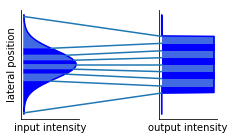

In [3]:
x = np.linspace(-7,7,200)
gaussian_w = 2
flattop_w = 4
segments = 8

gaussian_beam = np.exp(-x**2/(2*gaussian_w**2))
flattop_beam = np.zeros_like(x)
flattop_beam[np.abs(x) < flattop_w] = 7/flattop_w*np.mean(gaussian_beam)
zero_intensity_edge, full_intensity_edge = 0.005, 0.995

def find_edges(y, zero=0.0001, one=0.9999):
    cumsum = np.cumsum(y)/np.cumsum(y)[-1]
    return [(np.max if I<0.5 else np.min)(np.argwhere((cumsum-I)**2 == np.min((cumsum-I)**2)))
            for I in np.linspace(zero,one,segments+1)]
def segment_numbers(y, **kwargs):
    edges = find_edges(y, **kwargs)
    indices = np.arange(len(y))
    segment_numbers = np.zeros((len(y)), dtype=np.int)
    for i, (start, end) in enumerate(zip(edges[:-1], edges[1:])):
        segment_numbers[np.logical_and(start < indices, indices <= end)] = i
    return segment_numbers
def fill_segments(ax, x, y, colors=['blue','royalblue'], **kwargs):
    N = len(colors)
    snumbers = segment_numbers(y, **kwargs)
    for i in range(N):
        ax.fill_betweenx(x, y, where=snumbers % N == i, color=colors[i])

def hide_axes(ax):
    ax.patch.set_visible(False)
    for side in ['top','right']:
        ax.spines[side].set_visible(False)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_ticks([])
    
fig = plt.figure(figsize=(3.5,2))
gaussian_ax = fig.add_subplot(1,3,1)
gaussian_ax.plot(gaussian_beam, x, color="blue")
fill_segments(gaussian_ax, x, gaussian_beam)

hide_axes(gaussian_ax)
gaussian_ax.set_ylabel("lateral position")
gaussian_ax.set_xlabel("input intensity")

flattop_ax = fig.add_subplot(1,3,3)
flattop_ax.plot(flattop_beam, x, color="blue")
fill_segments(flattop_ax, x, flattop_beam)
hide_axes(flattop_ax)
flattop_ax.set_xlabel("output intensity")

# Join the edges of one plot to edges of the other
transFigure = fig.transFigure.inverted()

for i, (gi, fi) in enumerate(zip(find_edges(gaussian_beam), find_edges(flattop_beam))):
    coord1 = transFigure.transform(gaussian_ax.transData.transform([gaussian_beam[gi],x[gi]]))
    coord2 = transFigure.transform(flattop_ax.transData.transform([0,x[fi]]))
    fig.lines.append(matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                               transform=fig.transFigure))
fig.savefig("artwork/gaussian_to_flattop_1D.pdf",dpi=200)

**Figure:** Reshaping a Gaussian beam to a flat-top beam by redirecting light.  Each point on the input Gaussian beam (left) is redirected to the corresponding point in the flat-top beam.  The shaded sections in each beam each contain the same total power.  In the output beam these are equally sized as it has constant intensity.

We're working in 2D though, which is harder.  We simplify this by assuming the beam has radial symmetry.  The only change this makes to the simple 1D case is that we are now thinking about annuli rather than simple patches, so a constant-intensity beam has a power vs radius curve that is triangular rather than constant.

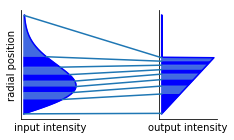

In [4]:
x = np.linspace(0,7,200)
gaussian_w = 2
flattop_w = 4
segments = 8

gaussian_beam = np.exp(-x**2/(2*gaussian_w**2)) * x/gaussian_w
flattop_beam = 7/flattop_w*np.mean(gaussian_beam) * x/gaussian_w
flattop_beam[np.abs(x) > flattop_w] = 0

fig = plt.figure(figsize=(3.5,2))
gaussian_ax = fig.add_subplot(1,3,1)
gaussian_ax.plot(gaussian_beam, x, color="blue")
fill_segments(gaussian_ax, x, gaussian_beam)

hide_axes(gaussian_ax)
gaussian_ax.set_ylabel("radial position")
gaussian_ax.set_xlabel("input intensity")

flattop_ax = fig.add_subplot(1,3,3)
flattop_ax.plot(flattop_beam, x, color="blue")
fill_segments(flattop_ax, x, flattop_beam)
hide_axes(flattop_ax)
flattop_ax.set_xlabel("output intensity")

# Join the edges of one plot to edges of the other
transFigure = fig.transFigure.inverted()

for i, (gi, fi) in enumerate(zip(find_edges(gaussian_beam), find_edges(flattop_beam))):
    coord1 = transFigure.transform(gaussian_ax.transData.transform([gaussian_beam[gi],x[gi]]))
    coord2 = transFigure.transform(flattop_ax.transData.transform([0,x[fi]]))
    fig.lines.append(matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                               transform=fig.transFigure))
fig.savefig("artwork/gaussian_to_flattop_radial.pdf", dpi=200)

**Figure:** Reshaping a 2D Gaussian beam to a 2D flat-top beam, by working in radial coordinates.  Note that the output beam is still constant intensity, but the power per unit radius increases as the area of an annulus increases with radius.

# Simulation of the experiment
Once we've calculated the wavefront that will reshape the beam, we can predict what will happen quite accurately using scalar beam propagation.  This propagates a beam by advancing the phase of each component in the Fourier domain - equivalently, it convolves the beam with a propagation operator for each step.  This allows us to include wave optical effects as well as the ray-optical picture we have discussed above.

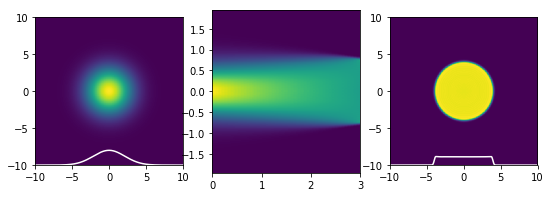

In [5]:
import slm_interference_lithography
from scipy.interpolate import interp1d

#reload(slm_interference_lithography)
#reload(beam)

slm = slm_interference_lithography.VeryCleverBeamsplitter(dummy=True)

# Define the simulation parameters
N = 512
beamsize = 20000.0
wavelength = 0.633
target_radius = 4000.0
propagation_distance = 3.0e6
slm.active_area = (10.7,10.7)
dr = beamsize/np.sqrt(2)/N
slm.radial_blaze_dr = 0.018
slm.focal_length = propagation_distance/1000.0
slm.wavevector = 2*np.pi/wavelength*1000


def set_input_beam_from_measurement(slm, r, I):
    """Set the SLM input beam from a set of measured (r, cumulative I) points"""
    normI = (I - np.min(I))/(np.max(I)-np.min(I))
    slm.input_beam_cumulative_I = np.interp(slm.input_beam_r, r, normI)
    
def radial_array_to_2d(r, f, target_beam):
    """Resample a function described by a set of r, f points to be 2D"""
    # interp1d returns a function
    function = interp1d(r, f, bounds_error=False, fill_value=0)
    r2d =  np.sqrt(target_beam.x**2+target_beam.y**2)
    # calling this function on a 2D array of r coordinates gives the 2D version
    return function(r2d)
    
def reshape_with_slm(initial_beam, slm, target_radius, slm_aperture=True, n_steps=100):
    """Simulate reshaping of the initial input beam using the SLM"""
    beamsize = np.max(initial_beam.x)-np.min(initial_beam.x)
    
    # First, we simulate an experimental measurement of this beam
    rs = np.arange(0, beamsize/np.sqrt(2), 100)
    Is = np.empty_like(rs)
    for i, r in enumerate(rs):
        # We measure total power inside the radius r by multiplying by an aperture and summing.
        aperture = beam.tophat_beam(N, beamsize/N, initial_beam.wavelength, r)
        Is[i] = np.sum(np.abs(initial_beam * aperture)**2)
    slm.set_input_beam(rs/1000, Is)

    # Next, calculate the phase shift as a function of radius
    slm.reshape_to_tophat(target_radius/1000, 3000)
    # Probably we want to split the function here in order to optimise the phase function
    phase_shift = radial_array_to_2d(slm.radial_phase_r*1000, slm.radial_phase_function, initial_beam)
    hologram = np.exp(1j * phase_shift)
    if slm_aperture:
        aa = slm.active_area
        hologram[np.abs(initial_beam.x)*np.ones_like(hologram) > aa[0]/2*1000] = 0
        hologram[np.abs(initial_beam.y)*np.ones_like(hologram) > aa[1]/2*1000] = 0
        
    # Apply the hologram and propagate
    propagation = beam.propagate_incremental(
        initial_beam * hologram, 
        propagation_distance/n_steps, 
        n_steps
        )
    
    return propagation

def show_beam_with_section(cross_section, ax, show_phase=False):
    beam.show_beam(cross_section, ax, show_phase=show_phase)
    ax.plot(cross_section.x/1000.0,
            np.abs(cross_section[:,cross_section.shape[1]//2])**2 * 2 + np.min(cross_section.y)/1000,
            color='white')
    ax.set_xlim((np.min(cross_section.x)/1000, np.max(cross_section.x)/1000))
    ax.set_ylim((np.min(cross_section.y)/1000, np.max(cross_section.y)/1000))
    
def before_prop_after_plot(propagation, show_phase=False):
    """plot a beam before, after, and a section through, propagation"""
    profile = (propagation[:,:,propagation.shape[2]//2])
    f, ax = plt.subplots(1,3,figsize=(9,3))
    show_beam_with_section(propagation[0,:,:], ax[0])
    beam.show_beam(profile.T,
                   ax[1],
                   extent=(0,propagation_distance/1e6,
                   np.min(profile.x)/1000,np.max(profile.x)/1000),
                   aspect="auto",
                   show_phase=False
                   )
    show_beam_with_section(propagation[-1,:,:],ax[2], show_phase=False)
    return f, ax
    

# We start with a Gaussian beam
initial_beam = beam.gaussian_beam(N, beamsize/N, wavelength, 3*1e3)
propagation = reshape_with_slm(initial_beam, slm, target_radius, slm_aperture=False)
before_prop_after_plot(propagation)
gaussian_propagation = propagation

This plot shows the input Gaussian beam propagating and evolving into the output flat-top beam.  Sections of the input and output beams are shown below the beam.

Text(0,0.5,'Phase/radians')

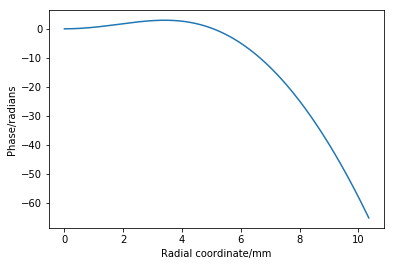

In [6]:
f, ax = plt.subplots(1,1)
ax.plot(slm.radial_phase_r,slm.radial_phase_function)
ax.set_xlabel("Radial coordinate/mm")
ax.set_ylabel("Phase/radians")

The phase function required to achieve this is shown above, unwrapped.  It looks a lot like a lens towards the edge, but in the middle we need to spread the beam out, hence the curvature changes.

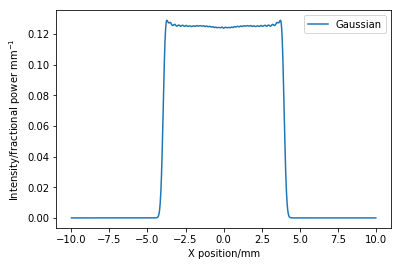

In [7]:
def intensity_x_section(propagation, step=-1):
    """Extract x, I of the final beam"""
    if step is None:
        step = -1
    x = propagation[step,:,:].x[:,0]/1000
    I = np.abs(propagation[step ,propagation.shape[1]//2, :])**2
    I /= np.sum(I) # normalise so it sums to 1
    I /= np.mean(np.diff(x)) # normalise so it integrates to 1 vs x
    return x, I

def plot_sections(propagations, steps=None, names=None):
    """Plot an I, x section through the propagations"""
    f, ax = plt.subplots(1,1)
    if steps is None:
        steps = [-1] * len(propagations)
    if names is None:
        names = [None] * len(propagations)
    for propagation, step, name in zip(propagations, steps, names):
        ax.plot(*intensity_x_section(propagation, step), label=name)
    ax.set_xlabel("X position/mm")
    ax.set_ylabel("Intensity/fractional power $\mathrm{mm}^{-1}$")
    return f, ax

f, ax = plot_sections([propagation], names=["Gaussian"])
ax.legend()

The output beam is very close to uniform - the achievable flatness is limited by the diffraction limit, and our requirement that we don't waste any intensity.

We can repeat the same thing with a truncated sinc beam, which is what you'd get if you use a pinhole and then an aperture to spatially filter the beam.  This has a hard edge (and is thus a more feasible beam to create in practice):

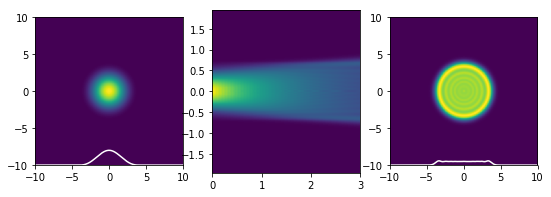

In [8]:
initial_beam = beam.truncated_sinc_beam(N, beamsize/N, wavelength, 4*1e3)
propagation = reshape_with_slm(initial_beam, slm, target_radius, slm_aperture=False)
before_prop_after_plot(propagation)
tsinc_propagation = propagation

Even with the right beam-shaping, a truncated sinc beam doesn't produce a nice flat-top beam, because of diffraction from the hard edge.

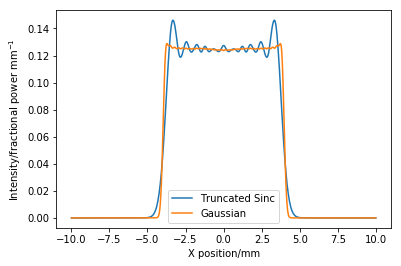

In [9]:
f, ax = plot_sections([tsinc_propagation, gaussian_propagation], names=["Truncated Sinc", "Gaussian"])
ax.legend()

Actually, the Gaussian beam here is unfairly advantaged - we've skipped the aperture on the SLM.  Let's repeat this again, with an aperture at the edge of the SLM's active area (which is square).

Text(0.5,0.98,'Output intensity')

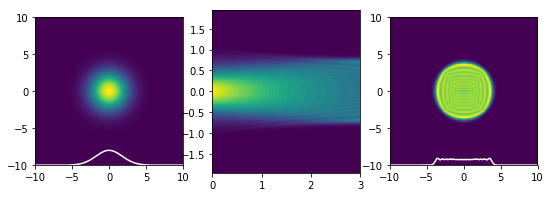

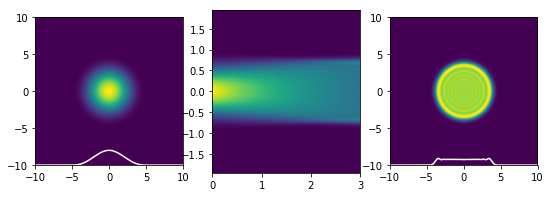

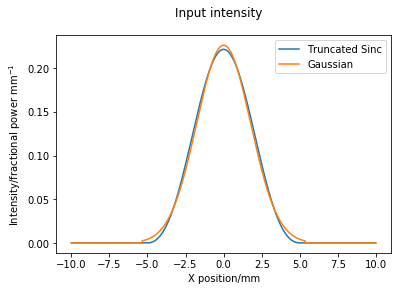

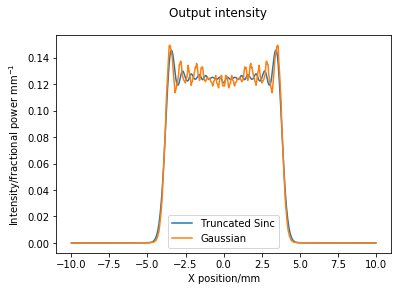

In [10]:
gaussian_propagation = reshape_with_slm(beam.gaussian_beam(N, beamsize/N, wavelength, 2.5*1e3),
                                        slm, target_radius, slm_aperture=True)
tsinc_propagation =    reshape_with_slm(beam.truncated_sinc_beam(N, beamsize/N, wavelength, 5*1e3),
                                        slm, target_radius, slm_aperture=True)
before_prop_after_plot(gaussian_propagation)
before_prop_after_plot(tsinc_propagation)
f, ax = plot_sections([tsinc_propagation, gaussian_propagation], names=["Truncated Sinc", "Gaussian"], steps=[0,0])
ax.legend()
f.suptitle("Input intensity")
f, ax = plot_sections([tsinc_propagation, gaussian_propagation], names=["Truncated Sinc", "Gaussian"])
ax.legend()
f.suptitle("Output intensity")

Above, we see that both beams now have fringes.  The Gaussian beam has high-frequency, square(ish) fringes from the edge of the SLM, and the truncated sinc beam has lower-frequency fringes from the hard edge of the beam - this is circular rather than square hence the symmetry of those fringes.  What we really need is a softer edge to the beam, while keeping it finite.

Text(0.5,0.98,'Output intensity')

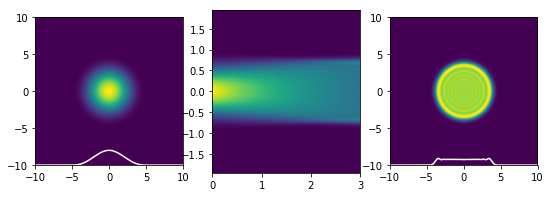

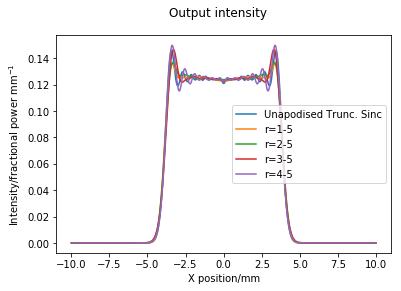

In [11]:
from slm_interference_lithography import RADIAL_ARRAY_LENGTH
def cosine_apodisation(r1, r2, slm):
    """A function that starts off at 1, then smoothly decreases from 1 to 0
    
    r1: the point at which we start decreasing
    r2: the point at which we hit zero
    slm: we use slm.radial_phase_r as the radial coordinate
    
    Between r1 and r2, we decrease as cos**2, i.e. df/dr is zero at start and end.
    """
    r = slm.radial_phase_r
    N_ones = np.argmax(r>r1)
    N_cos = np.argmax(r>r2) - N_ones
    N = len(r)
    return np.concatenate([np.ones(N_ones), 
                           np.cos(np.linspace(0, np.pi/2, N_cos))**2, 
                           np.zeros(N-N_ones-N_cos)])

def apodisation_2d(apodisation, slm, in_beam):
    """A 2D array that multiplies the input beam with the cosine_apodisation"""
    return radial_array_to_2d(slm.radial_phase_r*1000, apodisation, in_beam)

props = [tsinc_propagation]
names=["Unapodised Trunc. Sinc"]
in_beam = beam.truncated_sinc_beam(N, beamsize/N, wavelength, 5*1e3)
for apodisation, name in [(apodisation_2d(cosine_apodisation(1,5,slm), slm, in_beam), "r=1-5"),
                          (apodisation_2d(cosine_apodisation(2,5,slm), slm, in_beam), "r=2-5"),
                          (apodisation_2d(cosine_apodisation(3,5,slm), slm, in_beam), "r=3-5"),
                          (apodisation_2d(cosine_apodisation(4,5,slm), slm, in_beam), "r=4-5"),
                          ]:
    props.append(reshape_with_slm(in_beam*apodisation, slm, target_radius, slm_aperture=True, n_steps=1))
    names.append(name)

before_prop_after_plot(props[0])
    
f, ax = plot_sections(props, names=names, steps=None)
ax.legend()
f.suptitle("Output intensity")

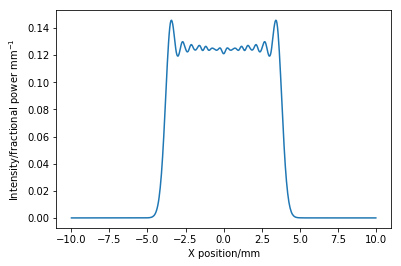

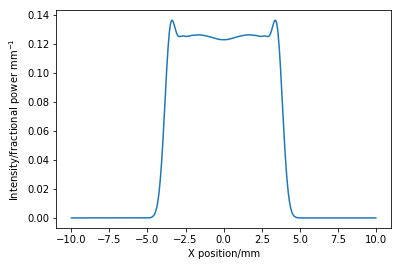

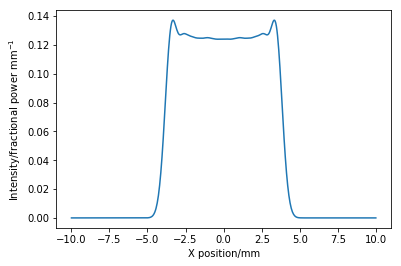

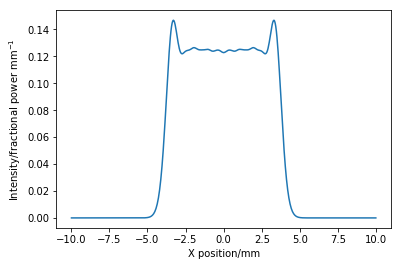

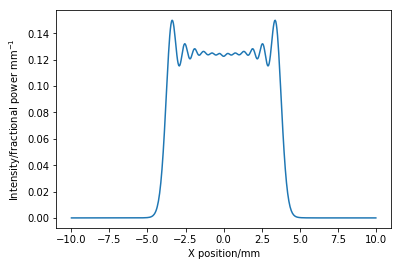

In [13]:
for p in props:
    f, ax = plot_sections([p])

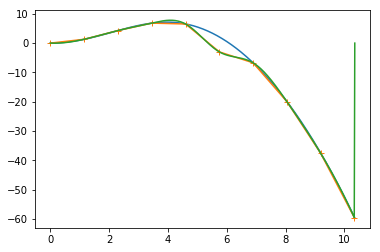

In [21]:
plt.plot(slm.radial_phase_r, slm.radial_phase_function)
rs = np.linspace(0,np.max(slm.radial_phase_r-0.01),10)
ps = []
for r in rs:
    ps.append(slm.radial_phase_function[np.argmax(slm.radial_phase_r > r)])
ps = np.array(ps)

ps[5] -= 5

plt.plot(rs, ps, "+-")
cubic_phase = interp1d(rs, ps, kind="cubic", bounds_error=False, fill_value=0)
plt.plot(slm.radial_phase_r, cubic_phase(slm.radial_phase_r))

NameError: name 'profile' is not defined

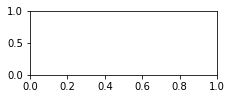

In [12]:
from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector, BboxConnectorPatch
import matplotlib.patches as patches

n_sections = 4
gs = plt.GridSpec(3,n_sections)
fig = plt.figure(figsize=(7,4))


centre_ax = fig.add_subplot(gs[1,1:n_sections-1])
beam.show_beam(propagation[:,N//2, N//4:3*N//4].T, centre_ax, extent=(0,propagation_distance,
                  np.min(profile.x)/1000,np.max(profile.x)/1000), aspect="auto")

# Join the edges of one plot to edges of the other
invFigTransform = fig.transFigure.inverted()
lineTransform = blended_transform_factory(centre_ax.transData, centre_ax.transAxes)

def swoosh(ax, start, host_axes=None, **kwargs):
    """Draw a polygonal call-out from a given point to an axes.  start should be in figure coords"""
    if host_axes is None:
        host_axes = ax
    
    # Connect each side of the box to the point - that way we're covered!
    #xn, xp, yn, yp = ax.get_xlim() + ax.get_ylim()
    #corners = [[xn, yn],[xn,yp],[xp,yp],[xp,yn]]
    corners = [[0,0],[0,1],[1,1],[1,0]]
    for c1, c2 in [(corners[i], corners[(i+1) % 4]) for i in range(4)]:
        p = patches.Polygon([ax.figure.transFigure.inverted().transform(ax.transAxes.transform(c1)),
                             ax.figure.transFigure.inverted().transform(ax.transAxes.transform(c2)),
                             start],
                            transform = host_axes.figure.transFigure, clip_on=False,
                            **kwargs
                           )
        host_axes.add_patch(p)

        
simulation_section_axes = [ fig.add_subplot(gs[0,i]) for i in range(4)]
for i, ax in enumerate(simulation_section_axes):
    cross_section = propagation[i*(propagation.shape[0]-1)//3, N//4:(3*N)//4, N//4:(3*N)//4]
    show_beam_with_section(cross_section, ax)
    
fig.tight_layout()
fig.canvas.draw() # Necessary to persuade axes to update themselves

for i, ax in enumerate(simulation_section_axes):
    line_z = propagation_distance * i/(n_sections - 1)
    centre_ax.axvline(x=line_z, color="white")
    
    swoosh_start = invFigTransform.transform(lineTransform.transform((line_z, 1)))
    swoosh(ax, swoosh_start, host_axes=centre_ax, fill=True, facecolor="gray", edgecolor="none")


    


In [ ]:
from slm_interference_lithography import VeryCleverBeamsplitter
from scipy.interpolate import interp1d

gaussian_to_tophat_phase = VeryCleverBeamsplitter.gaussian_to_tophat_phase

# Define the simulation parameters
N = 512
beamsize = 20000.0
wavelength = 0.4
initial_waist = 3000.0
target_radius = 4000.0
propagation_distance = 2.0e6
dr = beamsize/np.sqrt(2)/N

# We start with a Gaussian beam
initial_beam = beam.sinc_beam(N, beamsize/N, wavelength, initial_waist)

# Next, calculate the phase shift as a function of radius
phase_shift_array = gaussian_to_tophat_phase(N, dr, wavelength, initial_waist, target_radius, propagation_distance)
phase_shift = interp1d(np.arange(N)*dr, phase_shift_array)

# Turn this 1D radial array into a 2D complex array
r = np.sqrt(initial_beam.x**2+initial_beam.y**2)
hologram = np.exp(1j * phase_shift(r))
        
# Apply the hologram and propagate
propagation = beam.propagate_incremental(
    initial_beam * hologram, 
    propagation_distance/100, 
    100
    )

def overlay_x_section(ax, beam):
    """Overlay a section"""
def before_prop_after_plot(propagation):
    """plot a beam before, after, and a section through, propagation"""
    profile = (propagation[:,:,propagation.shape[2]//2])
    f, ax = plt.subplots(1,3,figsize=(9,3))
    show_beam_with_section(propagation[0,:,:], ax[0])
    beam.show_beam(profile.T,
                   ax[1],
                   extent=(0,propagation_distance/1e6,
                   np.min(profile.x)/1000,np.max(profile.x)/1000),
                   aspect="auto",
                   )
    show_beam_with_section(propagation[-1,:,:],ax[2])
    return f, ax
    
before_prop_after_plot(propagation)